In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [9]:
from utils import plot_confusion_matrix
from dataset import read_dataset, prepare_dataset
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from training import evaluate, training_loop

# MASS TRAINING 

## Read dataset and preprocess it

In [5]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader = prepare_dataset(all_trials, MASS_CLASS_COLS, normalise=True)

## Define model, loss and optimizer

In [7]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [10]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=200)

  0%|          | 1/200 [00:00<01:35,  2.09it/s]

1.099935531616211 tensor(38, device='cuda:0')


  1%|          | 2/200 [00:00<01:31,  2.16it/s]

1.0994775295257568 tensor(38, device='cuda:0')


  2%|▏         | 3/200 [00:01<01:28,  2.22it/s]

1.0990278720855713 tensor(40, device='cuda:0')


  2%|▏         | 4/200 [00:01<01:27,  2.24it/s]

1.098585844039917 tensor(38, device='cuda:0')


  2%|▎         | 5/200 [00:02<01:26,  2.24it/s]

1.0981500148773193 tensor(38, device='cuda:0')


  3%|▎         | 6/200 [00:02<01:26,  2.25it/s]

1.0977200269699097 tensor(37, device='cuda:0')


  4%|▎         | 7/200 [00:03<01:25,  2.25it/s]

1.0972951650619507 tensor(38, device='cuda:0')


  4%|▍         | 8/200 [00:03<01:24,  2.26it/s]

1.0968749523162842 tensor(39, device='cuda:0')


  4%|▍         | 9/200 [00:03<01:23,  2.28it/s]

1.0964586734771729 tensor(39, device='cuda:0')


  5%|▌         | 10/200 [00:04<01:20,  2.37it/s]

1.0960460901260376 tensor(40, device='cuda:0')


  6%|▌         | 11/200 [00:04<01:18,  2.39it/s]

1.0956363677978516 tensor(41, device='cuda:0')


  6%|▌         | 12/200 [00:05<01:17,  2.42it/s]

1.095228910446167 tensor(41, device='cuda:0')


  6%|▋         | 13/200 [00:05<01:16,  2.45it/s]

1.094822645187378 tensor(41, device='cuda:0')


  7%|▋         | 14/200 [00:05<01:15,  2.45it/s]

1.094416856765747 tensor(41, device='cuda:0')


  8%|▊         | 15/200 [00:06<01:14,  2.48it/s]

1.094010829925537 tensor(40, device='cuda:0')


  8%|▊         | 16/200 [00:06<01:14,  2.47it/s]

1.0936037302017212 tensor(40, device='cuda:0')


  8%|▊         | 17/200 [00:07<01:13,  2.49it/s]

1.0931938886642456 tensor(39, device='cuda:0')


  9%|▉         | 18/200 [00:07<01:12,  2.50it/s]

1.0927808284759521 tensor(38, device='cuda:0')


 10%|▉         | 19/200 [00:07<01:12,  2.49it/s]

1.0923634767532349 tensor(38, device='cuda:0')


 10%|█         | 20/200 [00:08<01:12,  2.50it/s]

1.091940999031067 tensor(40, device='cuda:0')


 10%|█         | 21/200 [00:08<01:12,  2.48it/s]

1.0915114879608154 tensor(40, device='cuda:0')


 11%|█         | 22/200 [00:09<01:11,  2.49it/s]

1.0910747051239014 tensor(40, device='cuda:0')


 12%|█▏        | 23/200 [00:09<01:10,  2.52it/s]

1.0906288623809814 tensor(40, device='cuda:0')


 12%|█▏        | 24/200 [00:09<01:09,  2.52it/s]

1.0901738405227661 tensor(39, device='cuda:0')


 12%|█▎        | 25/200 [00:10<01:09,  2.52it/s]

1.0897074937820435 tensor(38, device='cuda:0')


 13%|█▎        | 26/200 [00:10<01:09,  2.50it/s]

1.0892295837402344 tensor(38, device='cuda:0')


 14%|█▎        | 27/200 [00:11<01:09,  2.51it/s]

1.088738203048706 tensor(36, device='cuda:0')


 14%|█▍        | 28/200 [00:11<01:08,  2.53it/s]

1.0882329940795898 tensor(36, device='cuda:0')


 14%|█▍        | 29/200 [00:11<01:07,  2.52it/s]

1.0877121686935425 tensor(36, device='cuda:0')


 15%|█▌        | 30/200 [00:12<01:07,  2.51it/s]

1.0871750116348267 tensor(35, device='cuda:0')


 16%|█▌        | 31/200 [00:12<01:06,  2.54it/s]

1.0866206884384155 tensor(35, device='cuda:0')


 16%|█▌        | 32/200 [00:13<01:06,  2.52it/s]

1.0860477685928345 tensor(35, device='cuda:0')


 16%|█▋        | 33/200 [00:13<01:06,  2.50it/s]

1.0854547023773193 tensor(35, device='cuda:0')


 17%|█▋        | 34/200 [00:13<01:05,  2.52it/s]

1.0848408937454224 tensor(35, device='cuda:0')


 18%|█▊        | 35/200 [00:14<01:06,  2.49it/s]

1.0842050313949585 tensor(35, device='cuda:0')


 18%|█▊        | 36/200 [00:14<01:08,  2.41it/s]

1.0835459232330322 tensor(36, device='cuda:0')


 18%|█▊        | 37/200 [00:15<01:06,  2.43it/s]

1.082862377166748 tensor(36, device='cuda:0')


 19%|█▉        | 38/200 [00:15<01:07,  2.38it/s]

1.082153081893921 tensor(35, device='cuda:0')


 20%|█▉        | 39/200 [00:16<01:08,  2.35it/s]

1.0814167261123657 tensor(36, device='cuda:0')


 20%|██        | 40/200 [00:16<01:06,  2.42it/s]

1.080652117729187 tensor(36, device='cuda:0')


 20%|██        | 41/200 [00:16<01:05,  2.42it/s]

1.0798581838607788 tensor(36, device='cuda:0')


 21%|██        | 42/200 [00:17<01:04,  2.44it/s]

1.0790332555770874 tensor(36, device='cuda:0')


 22%|██▏       | 43/200 [00:17<01:03,  2.46it/s]

1.0781761407852173 tensor(36, device='cuda:0')


 22%|██▏       | 44/200 [00:18<01:04,  2.41it/s]

1.0772852897644043 tensor(36, device='cuda:0')


 22%|██▎       | 45/200 [00:18<01:05,  2.37it/s]

1.0763593912124634 tensor(36, device='cuda:0')


 23%|██▎       | 46/200 [00:18<01:04,  2.39it/s]

1.0753965377807617 tensor(36, device='cuda:0')


 24%|██▎       | 47/200 [00:19<01:03,  2.41it/s]

1.0743954181671143 tensor(37, device='cuda:0')


 24%|██▍       | 48/200 [00:19<01:03,  2.39it/s]

1.0733537673950195 tensor(38, device='cuda:0')


 24%|██▍       | 49/200 [00:20<01:03,  2.38it/s]

1.0722702741622925 tensor(38, device='cuda:0')


 25%|██▌       | 50/200 [00:20<01:02,  2.40it/s]

1.0711420774459839 tensor(38, device='cuda:0')


 26%|██▌       | 51/200 [00:20<01:01,  2.44it/s]

1.0699679851531982 tensor(38, device='cuda:0')


 26%|██▌       | 52/200 [00:21<01:01,  2.40it/s]

1.0687453746795654 tensor(38, device='cuda:0')


 26%|██▋       | 53/200 [00:21<01:01,  2.38it/s]

1.0674724578857422 tensor(39, device='cuda:0')


 27%|██▋       | 54/200 [00:22<01:01,  2.36it/s]

1.066146969795227 tensor(39, device='cuda:0')


 28%|██▊       | 55/200 [00:22<01:01,  2.35it/s]

1.0647673606872559 tensor(38, device='cuda:0')


 28%|██▊       | 56/200 [00:23<01:01,  2.35it/s]

1.063331961631775 tensor(39, device='cuda:0')


 28%|██▊       | 57/200 [00:23<01:00,  2.36it/s]

1.0618377923965454 tensor(39, device='cuda:0')


 29%|██▉       | 58/200 [00:23<00:58,  2.42it/s]

1.0602819919586182 tensor(38, device='cuda:0')


 30%|██▉       | 59/200 [00:24<00:57,  2.45it/s]

1.0586669445037842 tensor(38, device='cuda:0')


 30%|███       | 60/200 [00:24<00:56,  2.49it/s]

1.0570088624954224 tensor(38, device='cuda:0')


 30%|███       | 61/200 [00:25<00:55,  2.51it/s]

1.0553159713745117 tensor(37, device='cuda:0')


 31%|███       | 62/200 [00:25<00:55,  2.49it/s]

1.0535832643508911 tensor(36, device='cuda:0')


 32%|███▏      | 63/200 [00:25<00:55,  2.48it/s]

1.0518056154251099 tensor(37, device='cuda:0')


 32%|███▏      | 64/200 [00:26<00:56,  2.41it/s]

1.0499786138534546 tensor(37, device='cuda:0')


 32%|███▎      | 65/200 [00:26<00:52,  2.57it/s]

1.0480996370315552 tensor(37, device='cuda:0')


 33%|███▎      | 66/200 [00:27<00:53,  2.49it/s]

1.046165943145752 tensor(38, device='cuda:0')


 34%|███▎      | 67/200 [00:27<00:54,  2.45it/s]

1.0441745519638062 tensor(38, device='cuda:0')


 34%|███▍      | 68/200 [00:27<00:54,  2.41it/s]

1.042122483253479 tensor(38, device='cuda:0')


 34%|███▍      | 69/200 [00:28<00:53,  2.46it/s]

1.0400068759918213 tensor(39, device='cuda:0')


 35%|███▌      | 70/200 [00:28<00:52,  2.46it/s]

1.0378260612487793 tensor(39, device='cuda:0')


 36%|███▌      | 71/200 [00:29<00:52,  2.45it/s]

1.0355799198150635 tensor(40, device='cuda:0')


 36%|███▌      | 72/200 [00:29<00:51,  2.49it/s]

1.0332705974578857 tensor(40, device='cuda:0')


 36%|███▋      | 73/200 [00:30<00:52,  2.42it/s]

1.030902624130249 tensor(42, device='cuda:0')


 37%|███▋      | 74/200 [00:30<00:51,  2.44it/s]

1.0284819602966309 tensor(41, device='cuda:0')


 38%|███▊      | 75/200 [00:30<00:50,  2.45it/s]

1.026013970375061 tensor(41, device='cuda:0')


 38%|███▊      | 76/200 [00:31<00:50,  2.47it/s]

1.0235016345977783 tensor(41, device='cuda:0')


 38%|███▊      | 77/200 [00:31<00:49,  2.49it/s]

1.02094566822052 tensor(41, device='cuda:0')


 39%|███▉      | 78/200 [00:32<00:49,  2.46it/s]

1.018343448638916 tensor(42, device='cuda:0')


 40%|███▉      | 79/200 [00:32<00:51,  2.33it/s]

1.0156927108764648 tensor(42, device='cuda:0')


 40%|████      | 80/200 [00:32<00:51,  2.35it/s]

1.0129916667938232 tensor(43, device='cuda:0')


 40%|████      | 81/200 [00:33<00:50,  2.38it/s]

1.010239839553833 tensor(41, device='cuda:0')


 41%|████      | 82/200 [00:33<00:50,  2.36it/s]

1.0074374675750732 tensor(42, device='cuda:0')


 42%|████▏     | 83/200 [00:34<00:49,  2.37it/s]

1.0045857429504395 tensor(42, device='cuda:0')


 42%|████▏     | 84/200 [00:34<00:49,  2.35it/s]

1.001686453819275 tensor(42, device='cuda:0')


 42%|████▎     | 85/200 [00:35<00:49,  2.33it/s]

0.998742938041687 tensor(42, device='cuda:0')


 43%|████▎     | 86/200 [00:35<00:48,  2.35it/s]

0.9957598447799683 tensor(42, device='cuda:0')


 44%|████▎     | 87/200 [00:35<00:48,  2.35it/s]

0.9927427172660828 tensor(43, device='cuda:0')


 44%|████▍     | 88/200 [00:36<00:48,  2.32it/s]

0.9896928668022156 tensor(43, device='cuda:0')


 44%|████▍     | 89/200 [00:36<00:48,  2.30it/s]

0.986608624458313 tensor(43, device='cuda:0')


 45%|████▌     | 90/200 [00:37<00:48,  2.28it/s]

0.9834930300712585 tensor(43, device='cuda:0')


 46%|████▌     | 91/200 [00:37<00:48,  2.27it/s]

0.9803543090820312 tensor(43, device='cuda:0')


 46%|████▌     | 92/200 [00:38<00:47,  2.26it/s]

0.9771997332572937 tensor(42, device='cuda:0')


 46%|████▋     | 93/200 [00:38<00:47,  2.25it/s]

0.9740188717842102 tensor(42, device='cuda:0')


 47%|████▋     | 94/200 [00:39<00:47,  2.25it/s]

0.9707852602005005 tensor(41, device='cuda:0')


 48%|████▊     | 95/200 [00:39<00:45,  2.29it/s]

0.9674755930900574 tensor(41, device='cuda:0')


 48%|████▊     | 96/200 [00:39<00:44,  2.34it/s]

0.9640881419181824 tensor(41, device='cuda:0')


 48%|████▊     | 97/200 [00:40<00:43,  2.37it/s]

0.9606236219406128 tensor(41, device='cuda:0')


 49%|████▉     | 98/200 [00:40<00:42,  2.40it/s]

0.9570887684822083 tensor(41, device='cuda:0')


 50%|████▉     | 99/200 [00:41<00:41,  2.41it/s]

0.9534958600997925 tensor(42, device='cuda:0')


 50%|█████     | 100/200 [00:41<00:41,  2.43it/s]

0.9498308897018433 tensor(44, device='cuda:0')


 50%|█████     | 101/200 [00:41<00:40,  2.43it/s]

0.9461328387260437 tensor(44, device='cuda:0')


 51%|█████     | 102/200 [00:42<00:39,  2.45it/s]

0.9424214363098145 tensor(44, device='cuda:0')


 52%|█████▏    | 103/200 [00:42<00:39,  2.45it/s]

0.9386515617370605 tensor(44, device='cuda:0')


 52%|█████▏    | 104/200 [00:43<00:39,  2.45it/s]

0.9348348379135132 tensor(44, device='cuda:0')


 52%|█████▎    | 105/200 [00:43<00:38,  2.45it/s]

0.9310117959976196 tensor(45, device='cuda:0')


 53%|█████▎    | 106/200 [00:43<00:38,  2.43it/s]

0.9271906614303589 tensor(45, device='cuda:0')


 54%|█████▎    | 107/200 [00:44<00:39,  2.38it/s]

0.9232904314994812 tensor(46, device='cuda:0')


 54%|█████▍    | 108/200 [00:44<00:39,  2.34it/s]

0.9194754362106323 tensor(47, device='cuda:0')


 55%|█████▍    | 109/200 [00:45<00:39,  2.31it/s]

0.9156257510185242 tensor(46, device='cuda:0')


 55%|█████▌    | 110/200 [00:45<00:38,  2.33it/s]

0.9117789268493652 tensor(45, device='cuda:0')


 56%|█████▌    | 111/200 [00:46<00:37,  2.36it/s]

0.9078406095504761 tensor(45, device='cuda:0')


 56%|█████▌    | 112/200 [00:46<00:36,  2.38it/s]

0.9039190411567688 tensor(45, device='cuda:0')


 56%|█████▋    | 113/200 [00:46<00:37,  2.34it/s]

0.9004620313644409 tensor(45, device='cuda:0')


 57%|█████▋    | 114/200 [00:47<00:37,  2.31it/s]

0.8968253135681152 tensor(45, device='cuda:0')


 57%|█████▊    | 115/200 [00:47<00:37,  2.29it/s]

0.8928648233413696 tensor(45, device='cuda:0')


 58%|█████▊    | 116/200 [00:48<00:36,  2.27it/s]

0.8887424468994141 tensor(45, device='cuda:0')


 58%|█████▊    | 117/200 [00:48<00:35,  2.35it/s]

0.8845701217651367 tensor(46, device='cuda:0')


 59%|█████▉    | 118/200 [00:49<00:34,  2.37it/s]

0.8803678750991821 tensor(46, device='cuda:0')


 60%|█████▉    | 119/200 [00:49<00:33,  2.39it/s]

0.8759835958480835 tensor(45, device='cuda:0')


 60%|██████    | 120/200 [00:49<00:33,  2.42it/s]

0.8719240427017212 tensor(45, device='cuda:0')


 60%|██████    | 121/200 [00:50<00:32,  2.43it/s]

0.8676954507827759 tensor(44, device='cuda:0')


 61%|██████    | 122/200 [00:50<00:32,  2.44it/s]

0.864151656627655 tensor(43, device='cuda:0')


 62%|██████▏   | 123/200 [00:51<00:31,  2.45it/s]

0.8601380586624146 tensor(43, device='cuda:0')


 62%|██████▏   | 124/200 [00:51<00:30,  2.45it/s]

0.8560513257980347 tensor(43, device='cuda:0')


 62%|██████▎   | 125/200 [00:51<00:30,  2.45it/s]

0.8518955111503601 tensor(44, device='cuda:0')


 63%|██████▎   | 126/200 [00:52<00:30,  2.46it/s]

0.8476618528366089 tensor(44, device='cuda:0')


 64%|██████▎   | 127/200 [00:52<00:29,  2.45it/s]

0.8426302671432495 tensor(45, device='cuda:0')


 64%|██████▍   | 128/200 [00:53<00:29,  2.45it/s]

0.8378850221633911 tensor(45, device='cuda:0')


 64%|██████▍   | 129/200 [00:53<00:29,  2.44it/s]

0.833819568157196 tensor(44, device='cuda:0')


 65%|██████▌   | 130/200 [00:53<00:28,  2.45it/s]

0.8303756713867188 tensor(43, device='cuda:0')


 66%|██████▌   | 131/200 [00:54<00:28,  2.44it/s]

0.8262979388237 tensor(46, device='cuda:0')


 66%|██████▌   | 132/200 [00:54<00:27,  2.45it/s]

0.8229961395263672 tensor(46, device='cuda:0')


 66%|██████▋   | 133/200 [00:55<00:27,  2.44it/s]

0.8220316171646118 tensor(46, device='cuda:0')


 67%|██████▋   | 134/200 [00:55<00:27,  2.44it/s]

0.815890908241272 tensor(47, device='cuda:0')


 68%|██████▊   | 135/200 [00:56<00:26,  2.43it/s]

0.8122286796569824 tensor(47, device='cuda:0')


 68%|██████▊   | 136/200 [00:56<00:26,  2.45it/s]

0.808449387550354 tensor(47, device='cuda:0')


 68%|██████▊   | 137/200 [00:56<00:24,  2.57it/s]

0.8045681715011597 tensor(48, device='cuda:0')


 69%|██████▉   | 138/200 [00:57<00:23,  2.66it/s]

0.8004837036132812 tensor(48, device='cuda:0')


 70%|██████▉   | 139/200 [00:57<00:23,  2.56it/s]

0.7963045835494995 tensor(48, device='cuda:0')


 70%|███████   | 140/200 [00:57<00:23,  2.53it/s]

0.7921156287193298 tensor(48, device='cuda:0')


 70%|███████   | 141/200 [00:58<00:23,  2.50it/s]

0.7880162000656128 tensor(49, device='cuda:0')


 71%|███████   | 142/200 [00:58<00:23,  2.44it/s]

0.7838771343231201 tensor(49, device='cuda:0')


 72%|███████▏  | 143/200 [00:59<00:23,  2.43it/s]

0.7795382142066956 tensor(48, device='cuda:0')


 72%|███████▏  | 144/200 [00:59<00:23,  2.37it/s]

0.7797633409500122 tensor(48, device='cuda:0')


 72%|███████▎  | 145/200 [01:00<00:23,  2.34it/s]

0.7723104357719421 tensor(47, device='cuda:0')


 73%|███████▎  | 146/200 [01:00<00:22,  2.38it/s]

0.7686143517494202 tensor(47, device='cuda:0')


 74%|███████▎  | 147/200 [01:00<00:22,  2.38it/s]

0.7651019096374512 tensor(46, device='cuda:0')


 74%|███████▍  | 148/200 [01:01<00:22,  2.35it/s]

0.7615026831626892 tensor(46, device='cuda:0')


 74%|███████▍  | 149/200 [01:01<00:21,  2.34it/s]

0.7580909132957458 tensor(46, device='cuda:0')


 75%|███████▌  | 150/200 [01:02<00:21,  2.30it/s]

0.7547803521156311 tensor(46, device='cuda:0')


 76%|███████▌  | 151/200 [01:02<00:21,  2.32it/s]

0.7512890696525574 tensor(45, device='cuda:0')


 76%|███████▌  | 152/200 [01:03<00:20,  2.30it/s]

0.7478941679000854 tensor(45, device='cuda:0')


 76%|███████▋  | 153/200 [01:03<00:20,  2.32it/s]

0.7445124387741089 tensor(46, device='cuda:0')


 77%|███████▋  | 154/200 [01:03<00:19,  2.34it/s]

0.7410891056060791 tensor(46, device='cuda:0')


 78%|███████▊  | 155/200 [01:04<00:19,  2.31it/s]

0.7376483678817749 tensor(48, device='cuda:0')


 78%|███████▊  | 156/200 [01:04<00:19,  2.30it/s]

0.7342239618301392 tensor(47, device='cuda:0')


 78%|███████▊  | 157/200 [01:05<00:18,  2.33it/s]

0.730758547782898 tensor(48, device='cuda:0')


 79%|███████▉  | 158/200 [01:05<00:17,  2.34it/s]

0.7272582054138184 tensor(48, device='cuda:0')


 80%|███████▉  | 159/200 [01:06<00:17,  2.32it/s]

0.723720133304596 tensor(48, device='cuda:0')


 80%|████████  | 160/200 [01:06<00:17,  2.35it/s]

0.7200482487678528 tensor(49, device='cuda:0')


 80%|████████  | 161/200 [01:06<00:16,  2.31it/s]

0.7161663174629211 tensor(49, device='cuda:0')


 81%|████████  | 162/200 [01:07<00:16,  2.33it/s]

0.712255597114563 tensor(49, device='cuda:0')


 82%|████████▏ | 163/200 [01:07<00:15,  2.34it/s]

0.7086594700813293 tensor(49, device='cuda:0')


 82%|████████▏ | 164/200 [01:08<00:15,  2.28it/s]

0.7057923674583435 tensor(50, device='cuda:0')


 82%|████████▎ | 165/200 [01:08<00:15,  2.32it/s]

0.7093252539634705 tensor(50, device='cuda:0')


 83%|████████▎ | 166/200 [01:09<00:14,  2.31it/s]

0.7063509225845337 tensor(50, device='cuda:0')


 84%|████████▎ | 167/200 [01:09<00:14,  2.31it/s]

0.703179121017456 tensor(49, device='cuda:0')


 84%|████████▍ | 168/200 [01:10<00:13,  2.29it/s]

0.7020978331565857 tensor(48, device='cuda:0')


 84%|████████▍ | 169/200 [01:10<00:13,  2.29it/s]

0.6957014203071594 tensor(48, device='cuda:0')


 85%|████████▌ | 170/200 [01:10<00:13,  2.29it/s]

0.6950103044509888 tensor(48, device='cuda:0')


 86%|████████▌ | 171/200 [01:11<00:12,  2.32it/s]

0.6914138793945312 tensor(48, device='cuda:0')


 86%|████████▌ | 172/200 [01:11<00:12,  2.30it/s]

0.6895086765289307 tensor(48, device='cuda:0')


 86%|████████▋ | 173/200 [01:12<00:11,  2.28it/s]

0.6863152384757996 tensor(47, device='cuda:0')


 87%|████████▋ | 174/200 [01:12<00:11,  2.28it/s]

0.6833493113517761 tensor(47, device='cuda:0')


 88%|████████▊ | 175/200 [01:13<00:11,  2.27it/s]

0.681441068649292 tensor(47, device='cuda:0')


 88%|████████▊ | 176/200 [01:13<00:10,  2.26it/s]

0.6785372495651245 tensor(47, device='cuda:0')


 88%|████████▊ | 177/200 [01:13<00:10,  2.28it/s]

0.6758018136024475 tensor(48, device='cuda:0')


 89%|████████▉ | 178/200 [01:14<00:09,  2.31it/s]

0.673419713973999 tensor(48, device='cuda:0')


 90%|████████▉ | 179/200 [01:14<00:09,  2.29it/s]

0.6705083847045898 tensor(48, device='cuda:0')


 90%|█████████ | 180/200 [01:15<00:08,  2.31it/s]

0.6676633954048157 tensor(48, device='cuda:0')


 90%|█████████ | 181/200 [01:15<00:08,  2.30it/s]

0.6661465167999268 tensor(48, device='cuda:0')


 91%|█████████ | 182/200 [01:16<00:07,  2.31it/s]

0.6635941863059998 tensor(48, device='cuda:0')


 92%|█████████▏| 183/200 [01:16<00:07,  2.29it/s]

0.6630679368972778 tensor(50, device='cuda:0')


 92%|█████████▏| 184/200 [01:16<00:06,  2.32it/s]

0.6667941808700562 tensor(50, device='cuda:0')


 92%|█████████▎| 185/200 [01:17<00:06,  2.35it/s]

0.6605930924415588 tensor(50, device='cuda:0')


 93%|█████████▎| 186/200 [01:17<00:06,  2.32it/s]

0.6584794521331787 tensor(50, device='cuda:0')


 94%|█████████▎| 187/200 [01:18<00:05,  2.34it/s]

0.6561113595962524 tensor(50, device='cuda:0')


 94%|█████████▍| 188/200 [01:18<00:05,  2.37it/s]

0.6536365151405334 tensor(50, device='cuda:0')


 94%|█████████▍| 189/200 [01:19<00:04,  2.38it/s]

0.6511868238449097 tensor(48, device='cuda:0')


 95%|█████████▌| 190/200 [01:19<00:04,  2.42it/s]

0.6488319039344788 tensor(48, device='cuda:0')


 96%|█████████▌| 191/200 [01:19<00:03,  2.42it/s]

0.6463369131088257 tensor(48, device='cuda:0')


 96%|█████████▌| 192/200 [01:20<00:03,  2.43it/s]

0.6439076662063599 tensor(48, device='cuda:0')


 96%|█████████▋| 193/200 [01:20<00:02,  2.44it/s]

0.6415133476257324 tensor(48, device='cuda:0')


 97%|█████████▋| 194/200 [01:21<00:02,  2.45it/s]

0.6389466524124146 tensor(48, device='cuda:0')


 98%|█████████▊| 195/200 [01:21<00:02,  2.45it/s]

0.6355615854263306 tensor(49, device='cuda:0')


 98%|█████████▊| 196/200 [01:21<00:01,  2.44it/s]

0.6330295205116272 tensor(49, device='cuda:0')


 98%|█████████▊| 197/200 [01:22<00:01,  2.46it/s]

0.6303949356079102 tensor(48, device='cuda:0')


 99%|█████████▉| 198/200 [01:22<00:00,  2.40it/s]

0.6375091671943665 tensor(48, device='cuda:0')


100%|█████████▉| 199/200 [01:23<00:00,  2.35it/s]

0.6353481411933899 tensor(48, device='cuda:0')


100%|██████████| 200/200 [01:23<00:00,  2.31it/s]

0.6331796050071716 tensor(48, device='cuda:0')


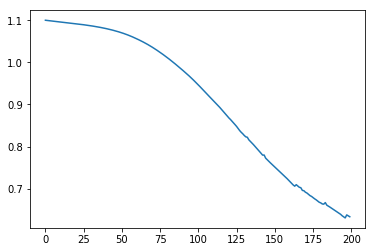

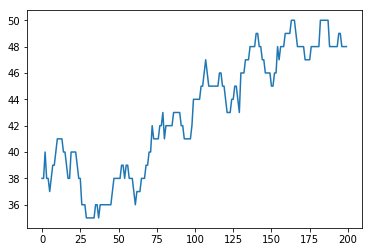

In [11]:
plt.plot(epoch_losses)
plt.show()
plt.plot(epoch_accuracies)
plt.show()

## Save model 

In [12]:
torch.save(model.state_dict(), "passive_mass_model.pt")

## Load model and evaluate

In [13]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [14]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [17]:
print(accuracy)

tensor(48, device='cuda:0')


In [15]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.array([y.cpu().numpy() for x, y in val_loader]).reshape(-1)

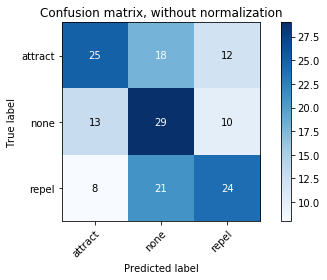

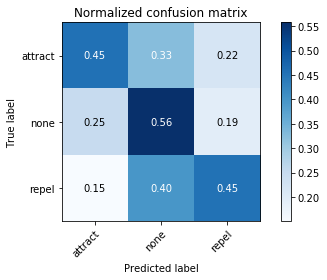

In [16]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)

# FORCE TRAINING 

## Read dataset and preprocess it

In [18]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader = prepare_dataset(all_trials, FORCE_CLASS_COLS, normalise=True)

## Define model, loss and optimizer

In [22]:
np.random.seed(62)
torch.manual_seed(72)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [23]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=200)

  0%|          | 1/200 [00:00<01:25,  2.32it/s]

1.1099849939346313 tensor(27, device='cuda:0')


  1%|          | 2/200 [00:00<01:20,  2.47it/s]

1.1092455387115479 tensor(27, device='cuda:0')


  2%|▏         | 3/200 [00:01<01:20,  2.45it/s]

1.1085174083709717 tensor(27, device='cuda:0')


  2%|▏         | 4/200 [00:01<01:20,  2.43it/s]

1.1077998876571655 tensor(27, device='cuda:0')


  2%|▎         | 5/200 [00:02<01:21,  2.40it/s]

1.1070935726165771 tensor(28, device='cuda:0')


  3%|▎         | 6/200 [00:02<01:22,  2.36it/s]

1.1063978672027588 tensor(30, device='cuda:0')


  4%|▎         | 7/200 [00:02<01:23,  2.32it/s]

1.1057125329971313 tensor(30, device='cuda:0')


  4%|▍         | 8/200 [00:03<01:23,  2.31it/s]

1.1050373315811157 tensor(29, device='cuda:0')


  4%|▍         | 9/200 [00:03<01:17,  2.46it/s]

1.1043719053268433 tensor(29, device='cuda:0')


  5%|▌         | 10/200 [00:04<01:18,  2.43it/s]

1.103716254234314 tensor(28, device='cuda:0')


  6%|▌         | 11/200 [00:04<01:13,  2.56it/s]

1.10306978225708 tensor(28, device='cuda:0')


  6%|▌         | 12/200 [00:04<01:14,  2.53it/s]

1.102432131767273 tensor(30, device='cuda:0')


  6%|▋         | 13/200 [00:05<01:15,  2.49it/s]

1.1018030643463135 tensor(30, device='cuda:0')


  7%|▋         | 14/200 [00:05<01:16,  2.42it/s]

1.101182222366333 tensor(30, device='cuda:0')


  8%|▊         | 15/200 [00:06<01:17,  2.38it/s]

1.1005687713623047 tensor(31, device='cuda:0')


  8%|▊         | 16/200 [00:06<01:18,  2.34it/s]

1.099962830543518 tensor(32, device='cuda:0')


  8%|▊         | 17/200 [00:07<01:18,  2.32it/s]

1.0993635654449463 tensor(31, device='cuda:0')


  9%|▉         | 18/200 [00:07<01:19,  2.30it/s]

1.098770260810852 tensor(32, device='cuda:0')


 10%|▉         | 19/200 [00:07<01:18,  2.32it/s]

1.0981829166412354 tensor(33, device='cuda:0')


 10%|█         | 20/200 [00:08<01:17,  2.32it/s]

1.0976004600524902 tensor(35, device='cuda:0')


 10%|█         | 21/200 [00:08<01:16,  2.33it/s]

1.0970226526260376 tensor(35, device='cuda:0')


 11%|█         | 22/200 [00:09<01:16,  2.33it/s]

1.0964481830596924 tensor(36, device='cuda:0')


 12%|█▏        | 23/200 [00:09<01:16,  2.33it/s]

1.0958774089813232 tensor(37, device='cuda:0')


 12%|█▏        | 24/200 [00:10<01:15,  2.32it/s]

1.095308780670166 tensor(38, device='cuda:0')


 12%|█▎        | 25/200 [00:10<01:14,  2.34it/s]

1.0947418212890625 tensor(38, device='cuda:0')


 13%|█▎        | 26/200 [00:10<01:14,  2.34it/s]

1.0941758155822754 tensor(38, device='cuda:0')


 14%|█▎        | 27/200 [00:11<01:14,  2.32it/s]

1.0936099290847778 tensor(38, device='cuda:0')


 14%|█▍        | 28/200 [00:11<01:14,  2.31it/s]

1.093043327331543 tensor(38, device='cuda:0')


 14%|█▍        | 29/200 [00:12<01:13,  2.34it/s]

1.0924752950668335 tensor(38, device='cuda:0')


 15%|█▌        | 30/200 [00:12<01:12,  2.34it/s]

1.0919045209884644 tensor(38, device='cuda:0')


 16%|█▌        | 31/200 [00:13<01:12,  2.32it/s]

1.0913307666778564 tensor(38, device='cuda:0')


 16%|█▌        | 32/200 [00:13<01:11,  2.35it/s]

1.0907528400421143 tensor(38, device='cuda:0')


 16%|█▋        | 33/200 [00:13<01:11,  2.34it/s]

1.0901693105697632 tensor(38, device='cuda:0')


 17%|█▋        | 34/200 [00:14<01:11,  2.33it/s]

1.0895798206329346 tensor(38, device='cuda:0')


 18%|█▊        | 35/200 [00:14<01:10,  2.35it/s]

1.0889827013015747 tensor(38, device='cuda:0')


 18%|█▊        | 36/200 [00:15<01:09,  2.35it/s]

1.0883774757385254 tensor(38, device='cuda:0')


 18%|█▊        | 37/200 [00:15<01:10,  2.33it/s]

1.0877625942230225 tensor(38, device='cuda:0')


 19%|█▉        | 38/200 [00:16<01:08,  2.35it/s]

1.08713698387146 tensor(38, device='cuda:0')


 20%|█▉        | 39/200 [00:16<01:08,  2.36it/s]

1.0864994525909424 tensor(38, device='cuda:0')


 20%|██        | 40/200 [00:16<01:07,  2.36it/s]

1.0858490467071533 tensor(38, device='cuda:0')


 20%|██        | 41/200 [00:17<01:07,  2.34it/s]

1.0851837396621704 tensor(38, device='cuda:0')


 21%|██        | 42/200 [00:17<01:07,  2.33it/s]

1.084502935409546 tensor(38, device='cuda:0')


 22%|██▏       | 43/200 [00:18<01:07,  2.34it/s]

1.0838038921356201 tensor(38, device='cuda:0')


 22%|██▏       | 44/200 [00:18<01:06,  2.36it/s]

1.083085298538208 tensor(38, device='cuda:0')


 22%|██▎       | 45/200 [00:19<01:05,  2.35it/s]

1.082344889640808 tensor(38, device='cuda:0')


 23%|██▎       | 46/200 [00:19<01:05,  2.34it/s]

1.0815802812576294 tensor(38, device='cuda:0')


 24%|██▎       | 47/200 [00:19<01:05,  2.33it/s]

1.0807898044586182 tensor(37, device='cuda:0')


 24%|██▍       | 48/200 [00:20<01:05,  2.33it/s]

1.0799739360809326 tensor(37, device='cuda:0')


 24%|██▍       | 49/200 [00:20<01:05,  2.31it/s]

1.0791350603103638 tensor(37, device='cuda:0')


 25%|██▌       | 50/200 [00:21<01:05,  2.30it/s]

1.0782725811004639 tensor(37, device='cuda:0')


 26%|██▌       | 51/200 [00:21<01:04,  2.30it/s]

1.0773845911026 tensor(37, device='cuda:0')


 26%|██▌       | 52/200 [00:22<01:04,  2.30it/s]

1.0764682292938232 tensor(38, device='cuda:0')


 26%|██▋       | 53/200 [00:22<01:04,  2.29it/s]

1.075521469116211 tensor(37, device='cuda:0')


 27%|██▋       | 54/200 [00:22<01:02,  2.33it/s]

1.0745418071746826 tensor(37, device='cuda:0')


 28%|██▊       | 55/200 [00:23<01:02,  2.32it/s]

1.0735282897949219 tensor(38, device='cuda:0')


 28%|██▊       | 56/200 [00:23<01:02,  2.30it/s]

1.0724796056747437 tensor(38, device='cuda:0')


 28%|██▊       | 57/200 [00:24<01:01,  2.33it/s]

1.0713956356048584 tensor(38, device='cuda:0')


 29%|██▉       | 58/200 [00:24<01:01,  2.33it/s]

1.0702753067016602 tensor(38, device='cuda:0')


 30%|██▉       | 59/200 [00:25<01:01,  2.31it/s]

1.0691173076629639 tensor(37, device='cuda:0')


 30%|███       | 60/200 [00:25<01:01,  2.29it/s]

1.0679199695587158 tensor(37, device='cuda:0')


 30%|███       | 61/200 [00:25<01:00,  2.29it/s]

1.0666823387145996 tensor(36, device='cuda:0')


 31%|███       | 62/200 [00:26<01:00,  2.28it/s]

1.0654045343399048 tensor(36, device='cuda:0')


 32%|███▏      | 63/200 [00:26<01:00,  2.27it/s]

1.0640881061553955 tensor(36, device='cuda:0')


 32%|███▏      | 64/200 [00:27<00:59,  2.30it/s]

1.062735915184021 tensor(35, device='cuda:0')


 32%|███▎      | 65/200 [00:27<00:58,  2.29it/s]

1.0613478422164917 tensor(35, device='cuda:0')


 33%|███▎      | 66/200 [00:28<00:57,  2.32it/s]

1.0599217414855957 tensor(36, device='cuda:0')


 34%|███▎      | 67/200 [00:28<00:57,  2.33it/s]

1.0584543943405151 tensor(36, device='cuda:0')


 34%|███▍      | 68/200 [00:28<00:56,  2.35it/s]

1.056943416595459 tensor(36, device='cuda:0')


 34%|███▍      | 69/200 [00:29<00:56,  2.32it/s]

1.0553854703903198 tensor(36, device='cuda:0')


 35%|███▌      | 70/200 [00:29<00:55,  2.35it/s]

1.0537779331207275 tensor(35, device='cuda:0')


 36%|███▌      | 71/200 [00:30<00:53,  2.41it/s]

1.0521177053451538 tensor(35, device='cuda:0')


 36%|███▌      | 72/200 [00:30<00:53,  2.41it/s]

1.0504003763198853 tensor(35, device='cuda:0')


 36%|███▋      | 73/200 [00:31<00:52,  2.43it/s]

1.0486209392547607 tensor(35, device='cuda:0')


 37%|███▋      | 74/200 [00:31<00:51,  2.43it/s]

1.0467743873596191 tensor(36, device='cuda:0')


 38%|███▊      | 75/200 [00:31<00:51,  2.44it/s]

1.044857144355774 tensor(37, device='cuda:0')


 38%|███▊      | 76/200 [00:32<00:50,  2.44it/s]

1.0428690910339355 tensor(38, device='cuda:0')


 38%|███▊      | 77/200 [00:32<00:50,  2.44it/s]

1.04081130027771 tensor(38, device='cuda:0')


 39%|███▉      | 78/200 [00:33<00:49,  2.45it/s]

1.0386892557144165 tensor(38, device='cuda:0')


 40%|███▉      | 79/200 [00:33<00:49,  2.44it/s]

1.0365114212036133 tensor(38, device='cuda:0')


 40%|████      | 80/200 [00:33<00:48,  2.45it/s]

1.0342800617218018 tensor(38, device='cuda:0')


 40%|████      | 81/200 [00:34<00:48,  2.44it/s]

1.0319890975952148 tensor(39, device='cuda:0')


 41%|████      | 82/200 [00:34<00:48,  2.46it/s]

1.029631495475769 tensor(39, device='cuda:0')


 42%|████▏     | 83/200 [00:35<00:47,  2.46it/s]

1.0272011756896973 tensor(39, device='cuda:0')


 42%|████▏     | 84/200 [00:35<00:47,  2.42it/s]

1.0246931314468384 tensor(39, device='cuda:0')


 42%|████▎     | 85/200 [00:35<00:48,  2.37it/s]

1.0221011638641357 tensor(40, device='cuda:0')


 43%|████▎     | 86/200 [00:36<00:48,  2.34it/s]

1.0194249153137207 tensor(40, device='cuda:0')


 44%|████▎     | 87/200 [00:36<00:47,  2.37it/s]

1.0166813135147095 tensor(40, device='cuda:0')


 44%|████▍     | 88/200 [00:37<00:46,  2.39it/s]

1.0138744115829468 tensor(40, device='cuda:0')


 44%|████▍     | 89/200 [00:37<00:46,  2.41it/s]

1.0110108852386475 tensor(39, device='cuda:0')


 45%|████▌     | 90/200 [00:38<00:45,  2.41it/s]

1.0080912113189697 tensor(40, device='cuda:0')


 46%|████▌     | 91/200 [00:38<00:45,  2.42it/s]

1.0051100254058838 tensor(40, device='cuda:0')


 46%|████▌     | 92/200 [00:38<00:44,  2.43it/s]

1.002068042755127 tensor(39, device='cuda:0')


 46%|████▋     | 93/200 [00:39<00:44,  2.42it/s]

0.9989713430404663 tensor(39, device='cuda:0')


 47%|████▋     | 94/200 [00:39<00:43,  2.44it/s]

0.9958229064941406 tensor(38, device='cuda:0')


 48%|████▊     | 95/200 [00:40<00:43,  2.44it/s]

0.9926190376281738 tensor(39, device='cuda:0')


 48%|████▊     | 96/200 [00:40<00:42,  2.45it/s]

0.9893498420715332 tensor(40, device='cuda:0')


 48%|████▊     | 97/200 [00:40<00:42,  2.44it/s]

0.9859987497329712 tensor(40, device='cuda:0')


 49%|████▉     | 98/200 [00:41<00:41,  2.45it/s]

0.9825426340103149 tensor(40, device='cuda:0')


 50%|████▉     | 99/200 [00:41<00:41,  2.44it/s]

0.9789894819259644 tensor(38, device='cuda:0')


 50%|█████     | 100/200 [00:42<00:41,  2.44it/s]

0.9753904342651367 tensor(39, device='cuda:0')


 50%|█████     | 101/200 [00:42<00:40,  2.45it/s]

0.9716647863388062 tensor(38, device='cuda:0')


 51%|█████     | 102/200 [00:42<00:40,  2.43it/s]

0.9678465127944946 tensor(38, device='cuda:0')


 52%|█████▏    | 103/200 [00:43<00:39,  2.43it/s]

0.9640231132507324 tensor(39, device='cuda:0')


 52%|█████▏    | 104/200 [00:43<00:39,  2.44it/s]

0.9602108001708984 tensor(39, device='cuda:0')


 52%|█████▎    | 105/200 [00:44<00:38,  2.44it/s]

0.9563848376274109 tensor(40, device='cuda:0')


 53%|█████▎    | 106/200 [00:44<00:38,  2.46it/s]

0.9525207281112671 tensor(40, device='cuda:0')


 54%|█████▎    | 107/200 [00:45<00:38,  2.45it/s]

0.9485771059989929 tensor(40, device='cuda:0')


 54%|█████▍    | 108/200 [00:45<00:37,  2.44it/s]

0.9444335103034973 tensor(40, device='cuda:0')


 55%|█████▍    | 109/200 [00:45<00:37,  2.44it/s]

0.9402798414230347 tensor(40, device='cuda:0')


 55%|█████▌    | 110/200 [00:46<00:37,  2.39it/s]

0.9360638856887817 tensor(40, device='cuda:0')


 56%|█████▌    | 111/200 [00:46<00:37,  2.35it/s]

0.9318089485168457 tensor(41, device='cuda:0')


 56%|█████▌    | 112/200 [00:47<00:37,  2.33it/s]

0.9274940490722656 tensor(42, device='cuda:0')


 56%|█████▋    | 113/200 [00:47<00:36,  2.35it/s]

0.9230826497077942 tensor(42, device='cuda:0')


 57%|█████▋    | 114/200 [00:48<00:36,  2.38it/s]

0.9185678362846375 tensor(42, device='cuda:0')


 57%|█████▊    | 115/200 [00:48<00:35,  2.39it/s]

0.914047360420227 tensor(41, device='cuda:0')


 58%|█████▊    | 116/200 [00:48<00:34,  2.40it/s]

0.9095690846443176 tensor(42, device='cuda:0')


 58%|█████▊    | 117/200 [00:49<00:34,  2.40it/s]

0.9050689935684204 tensor(43, device='cuda:0')


 59%|█████▉    | 118/200 [00:49<00:34,  2.41it/s]

0.9005097150802612 tensor(42, device='cuda:0')


 60%|█████▉    | 119/200 [00:50<00:33,  2.42it/s]

0.8958876729011536 tensor(43, device='cuda:0')


 60%|██████    | 120/200 [00:50<00:33,  2.42it/s]

0.8912602663040161 tensor(43, device='cuda:0')


 60%|██████    | 121/200 [00:50<00:32,  2.42it/s]

0.8866367340087891 tensor(43, device='cuda:0')


 61%|██████    | 122/200 [00:51<00:32,  2.43it/s]

0.8820640444755554 tensor(43, device='cuda:0')


 62%|██████▏   | 123/200 [00:51<00:31,  2.43it/s]

0.8773486018180847 tensor(43, device='cuda:0')


 62%|██████▏   | 124/200 [00:52<00:32,  2.34it/s]

0.8727286458015442 tensor(43, device='cuda:0')


 62%|██████▎   | 125/200 [00:52<00:31,  2.37it/s]

0.8679457902908325 tensor(44, device='cuda:0')


 63%|██████▎   | 126/200 [00:52<00:31,  2.38it/s]

0.8631747961044312 tensor(44, device='cuda:0')


 64%|██████▎   | 127/200 [00:53<00:30,  2.37it/s]

0.8587133288383484 tensor(44, device='cuda:0')


 64%|██████▍   | 128/200 [00:53<00:30,  2.40it/s]

0.8541404604911804 tensor(44, device='cuda:0')


 64%|██████▍   | 129/200 [00:54<00:29,  2.40it/s]

0.8495125770568848 tensor(44, device='cuda:0')


 65%|██████▌   | 130/200 [00:54<00:29,  2.39it/s]

0.8451007604598999 tensor(44, device='cuda:0')


 66%|██████▌   | 131/200 [00:55<00:28,  2.40it/s]

0.8405060768127441 tensor(44, device='cuda:0')


 66%|██████▌   | 132/200 [00:55<00:28,  2.41it/s]

0.836037814617157 tensor(45, device='cuda:0')


 66%|██████▋   | 133/200 [00:55<00:27,  2.42it/s]

0.8315184712409973 tensor(45, device='cuda:0')


 67%|██████▋   | 134/200 [00:56<00:27,  2.41it/s]

0.8268524408340454 tensor(46, device='cuda:0')


 68%|██████▊   | 135/200 [00:56<00:27,  2.38it/s]

0.822479248046875 tensor(47, device='cuda:0')


 68%|██████▊   | 136/200 [00:57<00:26,  2.40it/s]

0.8172895312309265 tensor(46, device='cuda:0')


 68%|██████▊   | 137/200 [00:57<00:26,  2.41it/s]

0.8124427795410156 tensor(46, device='cuda:0')


 69%|██████▉   | 138/200 [00:57<00:25,  2.43it/s]

0.8077572584152222 tensor(48, device='cuda:0')


 70%|██████▉   | 139/200 [00:58<00:25,  2.43it/s]

0.8025795817375183 tensor(48, device='cuda:0')


 70%|███████   | 140/200 [00:58<00:24,  2.43it/s]

0.7978748679161072 tensor(48, device='cuda:0')


 70%|███████   | 141/200 [00:59<00:24,  2.43it/s]

0.7935692071914673 tensor(48, device='cuda:0')


 71%|███████   | 142/200 [00:59<00:23,  2.43it/s]

0.7889954447746277 tensor(48, device='cuda:0')


 72%|███████▏  | 143/200 [01:00<00:23,  2.43it/s]

0.7845146656036377 tensor(48, device='cuda:0')


 72%|███████▏  | 144/200 [01:00<00:23,  2.42it/s]

0.7800346612930298 tensor(48, device='cuda:0')


 72%|███████▎  | 145/200 [01:00<00:22,  2.42it/s]

0.775361180305481 tensor(48, device='cuda:0')


 73%|███████▎  | 146/200 [01:01<00:22,  2.40it/s]

0.7711798548698425 tensor(48, device='cuda:0')


 74%|███████▎  | 147/200 [01:01<00:21,  2.42it/s]

0.7667683362960815 tensor(48, device='cuda:0')


 74%|███████▍  | 148/200 [01:02<00:21,  2.42it/s]

0.7623752951622009 tensor(48, device='cuda:0')


 74%|███████▍  | 149/200 [01:02<00:21,  2.40it/s]

0.7583886384963989 tensor(48, device='cuda:0')


 75%|███████▌  | 150/200 [01:02<00:20,  2.41it/s]

0.7587437033653259 tensor(48, device='cuda:0')


 76%|███████▌  | 151/200 [01:03<00:20,  2.42it/s]

0.7544920444488525 tensor(48, device='cuda:0')


 76%|███████▌  | 152/200 [01:03<00:19,  2.51it/s]

0.7505604028701782 tensor(48, device='cuda:0')


 76%|███████▋  | 153/200 [01:04<00:18,  2.49it/s]

0.7469536662101746 tensor(48, device='cuda:0')


 77%|███████▋  | 154/200 [01:04<00:18,  2.47it/s]

0.7438655495643616 tensor(48, device='cuda:0')


 78%|███████▊  | 155/200 [01:04<00:18,  2.46it/s]

0.7386199235916138 tensor(48, device='cuda:0')


 78%|███████▊  | 156/200 [01:05<00:18,  2.44it/s]

0.7353293895721436 tensor(48, device='cuda:0')


 78%|███████▊  | 157/200 [01:05<00:17,  2.44it/s]

0.7311211228370667 tensor(48, device='cuda:0')


 79%|███████▉  | 158/200 [01:06<00:17,  2.43it/s]

0.7273606657981873 tensor(48, device='cuda:0')


 80%|███████▉  | 159/200 [01:06<00:16,  2.42it/s]

0.7234355211257935 tensor(50, device='cuda:0')


 80%|████████  | 160/200 [01:07<00:16,  2.42it/s]

0.719572901725769 tensor(51, device='cuda:0')


 80%|████████  | 161/200 [01:07<00:16,  2.42it/s]

0.7195984125137329 tensor(51, device='cuda:0')


 81%|████████  | 162/200 [01:07<00:15,  2.43it/s]

0.715394914150238 tensor(51, device='cuda:0')


 82%|████████▏ | 163/200 [01:08<00:15,  2.43it/s]

0.7117272615432739 tensor(51, device='cuda:0')


 82%|████████▏ | 164/200 [01:08<00:14,  2.47it/s]

0.7078446745872498 tensor(51, device='cuda:0')


 82%|████████▎ | 165/200 [01:09<00:14,  2.47it/s]

0.7017877697944641 tensor(53, device='cuda:0')


 83%|████████▎ | 166/200 [01:09<00:13,  2.46it/s]

0.6982455849647522 tensor(53, device='cuda:0')


 84%|████████▎ | 167/200 [01:09<00:13,  2.41it/s]

0.6946998834609985 tensor(52, device='cuda:0')


 84%|████████▍ | 168/200 [01:10<00:13,  2.37it/s]

0.6912287473678589 tensor(52, device='cuda:0')


 84%|████████▍ | 169/200 [01:10<00:13,  2.34it/s]

0.6879884004592896 tensor(53, device='cuda:0')


 85%|████████▌ | 170/200 [01:11<00:12,  2.33it/s]

0.6844696402549744 tensor(52, device='cuda:0')


 86%|████████▌ | 171/200 [01:11<00:12,  2.31it/s]

0.6810051202774048 tensor(52, device='cuda:0')


 86%|████████▌ | 172/200 [01:12<00:12,  2.30it/s]

0.6792626976966858 tensor(52, device='cuda:0')


 86%|████████▋ | 173/200 [01:12<00:11,  2.30it/s]

0.6742120385169983 tensor(52, device='cuda:0')


 87%|████████▋ | 174/200 [01:12<00:11,  2.29it/s]

0.6709884405136108 tensor(51, device='cuda:0')


 88%|████████▊ | 175/200 [01:13<00:10,  2.29it/s]

0.667544960975647 tensor(51, device='cuda:0')


 88%|████████▊ | 176/200 [01:13<00:10,  2.28it/s]

0.6642835140228271 tensor(52, device='cuda:0')


 88%|████████▊ | 177/200 [01:14<00:10,  2.28it/s]

0.6610966324806213 tensor(52, device='cuda:0')


 89%|████████▉ | 178/200 [01:14<00:09,  2.28it/s]

0.6579176187515259 tensor(52, device='cuda:0')


 90%|████████▉ | 179/200 [01:15<00:09,  2.29it/s]

0.6559381484985352 tensor(52, device='cuda:0')


 90%|█████████ | 180/200 [01:15<00:08,  2.31it/s]

0.6528962850570679 tensor(52, device='cuda:0')


 90%|█████████ | 181/200 [01:16<00:08,  2.30it/s]

0.6497243642807007 tensor(52, device='cuda:0')


 91%|█████████ | 182/200 [01:16<00:07,  2.29it/s]

0.6461912393569946 tensor(52, device='cuda:0')


 92%|█████████▏| 183/200 [01:16<00:07,  2.29it/s]

0.6434378623962402 tensor(52, device='cuda:0')


 92%|█████████▏| 184/200 [01:17<00:07,  2.28it/s]

0.64082932472229 tensor(52, device='cuda:0')


 92%|█████████▎| 185/200 [01:17<00:06,  2.28it/s]

0.6380501389503479 tensor(52, device='cuda:0')


 93%|█████████▎| 186/200 [01:18<00:06,  2.28it/s]

0.6354464292526245 tensor(50, device='cuda:0')


 94%|█████████▎| 187/200 [01:18<00:05,  2.31it/s]

0.6327840089797974 tensor(50, device='cuda:0')


 94%|█████████▍| 188/200 [01:19<00:05,  2.33it/s]

0.6301264762878418 tensor(50, device='cuda:0')


 94%|█████████▍| 189/200 [01:19<00:04,  2.36it/s]

0.6225723028182983 tensor(51, device='cuda:0')


 95%|█████████▌| 190/200 [01:19<00:04,  2.47it/s]

0.6196938157081604 tensor(50, device='cuda:0')


 96%|█████████▌| 191/200 [01:20<00:03,  2.45it/s]

0.6189525127410889 tensor(50, device='cuda:0')


 96%|█████████▌| 192/200 [01:20<00:03,  2.43it/s]

0.6163569092750549 tensor(50, device='cuda:0')


 96%|█████████▋| 193/200 [01:21<00:02,  2.40it/s]

0.6137178540229797 tensor(50, device='cuda:0')


 97%|█████████▋| 194/200 [01:21<00:02,  2.41it/s]

0.6108750104904175 tensor(50, device='cuda:0')


 98%|█████████▊| 195/200 [01:21<00:01,  2.51it/s]

0.607994556427002 tensor(50, device='cuda:0')


 98%|█████████▊| 196/200 [01:22<00:01,  2.47it/s]

0.6074331402778625 tensor(50, device='cuda:0')


 98%|█████████▊| 197/200 [01:22<00:01,  2.45it/s]

0.6034809350967407 tensor(50, device='cuda:0')


 99%|█████████▉| 198/200 [01:23<00:00,  2.44it/s]

0.6050660610198975 tensor(50, device='cuda:0')


100%|█████████▉| 199/200 [01:23<00:00,  2.43it/s]

0.5993577837944031 tensor(50, device='cuda:0')


100%|██████████| 200/200 [01:23<00:00,  2.43it/s]

0.5970070362091064 tensor(50, device='cuda:0')


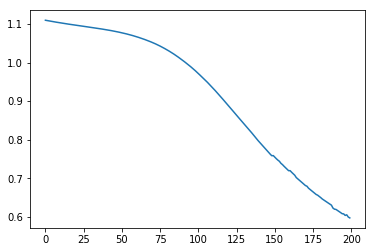

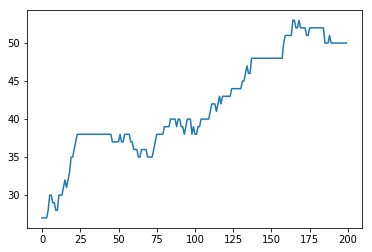

In [24]:
plt.plot(epoch_losses)
plt.show()
plt.plot(epoch_accuracies)
plt.show()

## Save model 

In [25]:
torch.save(model.state_dict(), "passive_force_model.pt")

## Load model and evaluate

In [26]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("passive_force_model.pt"))
model.eval()
model = model.cuda()

In [27]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [28]:
print(accuracy)

tensor(50, device='cuda:0')


In [29]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.array([y.cpu().numpy() for x, y in val_loader]).reshape(-1)

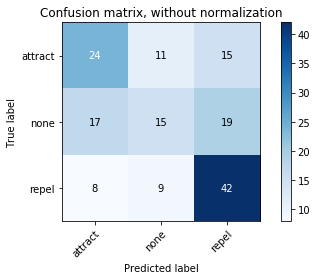

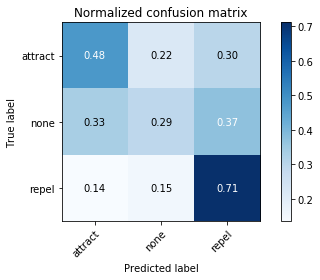

In [30]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)